## Download Data

In [ ]:
!pip install fiftyone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

drive  sample_data


In [ ]:
%cd /content/drive/MyDrive/Person_Tracking/YOLO
!ls ../fiftyone/coco-2017

/content/drive/.shortcut-targets-by-id/1adDKRN41tu-JRGosu5XQfU0vaZqeAwuV/Person_Tracking/YOLO
info.json  raw	train  validation


In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

# Load the COCO-2017 dataset
# This will download it from the FiftyOne Dataset Zoo if necessary

train_dir = "../fiftyone/coco-2017/train"
test_dir = "../fiftyone/coco-2017/validation"

train_dataset = fo.Dataset.from_dir(
    dataset_dir = train_dir,
    dataset_type = fo.types.COCODetectionDataset,
    label_types = ["detections"],
    classes = ["person"]
)

test_dataset = fo.Dataset.from_dir(
    dataset_dir = test_dir,
    dataset_type = fo.types.COCODetectionDataset,
    label_types=["detections"],
    classes = ["person"]
)
# Print summary information about the view
print(train_dataset)

 100% |███████████████| 3000/3000 [23.5s elapsed, 0s remaining, 152.8 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3000/3000 [23.5s elapsed, 0s remaining, 152.8 samples/s]      


 100% |█████████████████| 500/500 [5.4s elapsed, 0s remaining, 86.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 500/500 [5.4s elapsed, 0s remaining, 86.6 samples/s]      


Name:        2023.06.09.07.40.23
Media type:  image
Num samples: 3000
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [ ]:
# Iterate over the dataset
for sample in train_dataset:
    # Get the detections
    detections = sample.ground_truth.detections
    # Filter out non-person detections
    detections = [d for d in detections if d.label == "person"]
    # Update the detections
    sample.ground_truth.detections = detections
    # Save the sample
    sample.save()

In [ ]:
# Iterate over the dataset
for sample in test_dataset:
    # Get the detections
    detections = sample.ground_truth.detections
    # Filter out non-person detections
    detections = [d for d in detections if d.label == "person"]
    # Update the detections
    sample.ground_truth.detections = detections
    # Save the sample
    sample.save()

## Datasets Loader

In [ ]:
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]  # Note these have been rescaled to be between [0, 1]

In [ ]:
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
import numpy as np

def iou_width_height(boxes1, boxes2): #Iou untuk menghitung anchor
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union

class CocoPersonDataset(Dataset):
  def __init__(self, coco_dataset, anchors=ANCHORS, S=[13, 26, 52], transforms=None):
    self.coco_dataset = coco_dataset
    self.person_category_id = 0  # Person category ID in COCO dataset

    # Save sample IDs
    self.ids = [sample.id for sample in coco_dataset]

    self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
    self.num_anchors = self.anchors.shape[0]
    self.num_anchors_per_scale = self.num_anchors // 3
    self.S = S
    self.ignore_iou_thresh = 0.5

    # Define data augmentation transforms
    if transforms is None:
        self.transforms = A.Compose([
            A.Resize(height=416, width=416),
            A.Normalize(),
            ToTensorV2(),
        ])
    else:
        self.transforms = transforms

  def __len__(self):
    return len(self.coco_dataset)

  def __getitem__(self, idx):
    sample_id = self.ids[idx]
    sample = self.coco_dataset[sample_id]

    # Load image and annotations
    image = Image.open(sample.filepath).convert('RGB')
    image = np.array(image)
    annotations = sample.ground_truth.detections

    # Extract bounding boxes and convert to YOLO format
    bboxes = []
    for annotation in annotations:
        bbox = annotation.bounding_box
        x, y, width, height = bbox
        xc = x + width / 2
        yc = y + height / 2
        w = width
        h = height
        bboxes.append([xc, yc, w, h, self.person_category_id])

    # Apply data augmentation transforms
    if self.transforms:
      augmented = self.transforms(image=image)
      image = augmented["image"]

    bboxes = torch.tensor(bboxes)

    targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]

    for box in bboxes:
        iou_anchors = iou_width_height(torch.tensor(box[2:4]), self.anchors)
        anchor_indices = iou_anchors.argsort(descending=True, dim=0) #diurutin dari iou yang paling besar untuk index
        x, y, width, height, class_label = box
        has_anchor = [False] * 3  # each scale should have one anchor

        for anchor_idx in anchor_indices:
          scale_idx = anchor_idx // self.num_anchors_per_scale # untuk mendapatkan kira kira bounding box ini ada di scale yang mana
          anchor_on_scale = anchor_idx % self.num_anchors_per_scale

          S = self.S[scale_idx]
          i, j = int(S * y), int(S * x)  # which cell
          anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
          if not anchor_taken and not has_anchor[scale_idx]: #memproses atau menconvert x,y,w,h yang berdasarkan gambar scale nya menjadi berdasarkan grid dari setiap scale nya
            targets[scale_idx][anchor_on_scale, i, j, 0] = 1
            x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
            width_cell, height_cell = (
                width * S,
                height * S,
            )  # can be greater than 1 since it's relative to cell
            box_coordinates = torch.tensor(
                [x_cell, y_cell, width_cell, height_cell]
            )
            targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
            targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
            has_anchor[scale_idx] = True

          elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
              targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction


    return image, tuple(targets)


In [ ]:
NUM_CLASSES = 1
NUM_EPOCHS = 20
BATCH_SIZE = 4
CONF_THRESHOLD = 0.05

train_data = CocoPersonDataset(train_dataset)
test_data = CocoPersonDataset(test_dataset)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=2
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=2
)

## Utils

In [ ]:
!wget https://raw.githubusercontent.com/IndonesiaAI/yolov3-utils/main/utils.py

--2023-06-08 10:21:19--  https://raw.githubusercontent.com/IndonesiaAI/yolov3-utils/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12325 (12K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  12.04K  --.-KB/s    in 0.002s  

2023-06-08 10:21:19 (7.25 MB/s) - ‘utils.py’ saved [12325/12325]



## Metrics

In [ ]:
from utils import intersection_over_union, non_max_suppression, mean_average_precision, get_evaluation_bboxes, cells_to_bboxes, plot_image

## Modeling

In [ ]:
import torch
import torch.nn as nn

"""
Information about architecture config:
Tuple is structured by (filters, kernel_size, stride)
Every conv is a same convolution.
List is structured by "B" indicating a residual block followed by the number of repeats
"S" is for scale prediction block and computing the yolo loss
"U" is for upsampling the feature map and concatenating with a previous layer
"""
config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

In [ ]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
    self.use_bn_act = bn_act
    if bn_act:
      self.bn = nn.BatchNorm2d(out_channels)
      self.leaky = nn.LeakyReLU(0.1)

  def forward(self, x):
    if self.use_bn_act:
      return self.leaky(self.bn(self.conv(x)))
    else:
      return self.conv(x)

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, channels, use_residual=True, num_repeats=1):
    super().__init__()
    self.layers = nn.ModuleList()
    for repeat in range(num_repeats):
      self.layers += [nn.Sequential(
          CNNBlock(channels, channels//2, kernel_size=1),
          CNNBlock(channels//2, channels, kernel_size=3, padding=1)
      )]

      self.use_residual = use_residual
      self.num_repeats = num_repeats

  def forward(self, x):
    for layer in self.layers:
      if self.use_residual:
        x = x + layer(x)
      else:
        x = layer(x)

    return x

In [ ]:
class ScalePrediction(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.pred = nn.Sequential(
        CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
        CNNBlock(2*in_channels, (num_classes+5)*3, bn_act=False, kernel_size=1)
    )

    self.num_classes = num_classes

  def forward(self, x):
    # B, C=(3*(num_classes+5)), H, W -> B, 3, num_classes+5, 13, 13 -> B, 3, 13,13, num_classes+5
    return self.pred(x).reshape(x.shape[0], 3, self.num_classes+5, x.shape[2], x.shape[3]).permute(0,1,3,4,2)

In [ ]:
class YOLOV3(nn.Module):
  def __init__(self, in_channels=3, num_classes=20):
    super().__init__()
    self.num_classes = num_classes
    self.in_channels = in_channels
    self.layers = self._create_conv_layers()

  def _create_conv_layers(self):
    layers = nn.ModuleList()
    in_channels = self.in_channels

    for module in config:
      if isinstance(module, tuple):
        out_channels, kernel_size, stride = module
        layers.append(CNNBlock(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding = 1 if kernel_size == 3 else 0))
        in_channels = out_channels
      elif isinstance(module, list):
        num_repeats = module[1]
        layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))
      elif isinstance(module, str):
        if module == "S":
            layers += [
                ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                ScalePrediction(in_channels // 2, num_classes=self.num_classes),
            ]
            in_channels = in_channels // 2

        elif module == "U":
            layers.append(nn.Upsample(scale_factor=2),)
            in_channels = in_channels * 3
    return layers


  def forward(self, x):
    outputs = []  # for each scale
    route_connections = [] # untuk menyimpan residual value yang akan di concat pada saat setelah upsampling
    for layer in self.layers:
        if isinstance(layer, ScalePrediction):
            outputs.append(layer(x))
            continue

        x = layer(x)

        if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
            route_connections.append(x)

        elif isinstance(layer, nn.Upsample):
            x = torch.cat([x, route_connections[-1]], dim=1)
            route_connections.pop()

    return outputs

In [ ]:
model = YOLOV3(3, 1) #RGB, 1 jumlah kelas

dummy_input = torch.randn((1,3,416,416))
out = model(dummy_input)
print([ou.shape for ou in out])

[torch.Size([1, 3, 13, 13, 6]), torch.Size([1, 3, 26, 26, 6]), torch.Size([1, 3, 52, 52, 6])]


## Loss

In [ ]:
"""
Implementation of Yolo Loss Function similar to the one in Yolov3 paper,
the difference from what I can tell is I use CrossEntropy for the classes
instead of BinaryCrossEntropy.
"""
import random
import torch
import torch.nn as nn


class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        # Check where obj and noobj (we ignore if target == -1)
        obj = target[..., 0] == 1  # in paper this is Iobj_i
        noobj = target[..., 0] == 0  # in paper this is Inoobj_i

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.bce(
            (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        anchors = anchors.reshape(1, 3, 1, 1, 2)
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
        object_loss = self.mse(self.sigmoid(predictions[..., 0:1][obj]), ious * target[..., 0:1][obj])

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])  # x,y coordinates
        target[..., 3:5] = torch.log(
            (1e-16 + target[..., 3:5] / anchors)
        )  # width, height coordinates
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.entropy(
            (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
        )

        #print("__________________________________")
        #print(self.lambda_box * box_loss)
        #print(self.lambda_obj * object_loss)
        #print(self.lambda_noobj * no_object_loss)
        #print(self.lambda_class * class_loss)
        #print("\n")

        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
        )

## Train Phase and Evaluation Phase

In [ ]:
import torch
import torch.optim as optim

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

torch.backends.cudnn.benchmark = True

def train_epoch(model, dataloader, optimizer, loss_fn, scaled_anchors, device):
  #do training and calculate training loss
  loop = tqdm(dataloader, leave=True)
  losses = []
  for batch_idx, (x, y) in enumerate(loop):
      x = x.to(device)
      y0, y1, y2 = (
          y[0].to(device),
          y[1].to(device),
          y[2].to(device),
      )

      with torch.cuda.amp.autocast():
          out = model(x)
          loss = (
              loss_fn(out[0], y0, scaled_anchors[0])
              + loss_fn(out[1], y1, scaled_anchors[1])
              + loss_fn(out[2], y2, scaled_anchors[2])
          )

      losses.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # update progress bar
      mean_loss = sum(losses) / len(losses)
      loop.set_postfix(loss=mean_loss)

def evaluate(model, dataloader, device):
  #calculate mAP for the data evaluation, don't forget to run NMS first before do the mean Average Precision
  pred_boxes, true_boxes = get_evaluation_bboxes(
      dataloader,
      model,
      iou_threshold=0.45,
      anchors=ANCHORS,
      threshold=0.5
  )

  map = mean_average_precision(
      pred_boxes,
      true_boxes,
      iou_threshold=0.5,
      box_format="midpoint",
      num_classes=1
  )

  print(f"MAP: {map.item()}")
  model.train()

In [ ]:
def train():
  #do initialization of model, loss, optimizer and do the training and evaluation based on how many epochs also save the model
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  model = YOLOV3(3, 1)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  S = torch.tensor([13, 26, 52]).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
  scaled_anchors = (
      torch.tensor(ANCHORS)
      * S
  ).to(device)

  loss_fn = YoloLoss()

  for epoch in range(NUM_EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {NUM_EPOCHS}")
    #plot_couple_examples(model, test_loader, 0.6, 0.5, scaled_anchors)
    train_epoch(model, train_dataloader, optimizer, loss_fn, scaled_anchors, device)

    # save current epoch model
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, "last_model_2.pt")

    evaluate(model, test_dataloader, device)

In [ ]:
train()

[INFO]: Epoch 1 of 20


100%|██████████| 125/125 [00:39<00:00,  3.20it/s]


MAP: 0.0
[INFO]: Epoch 2 of 20


100%|██████████| 125/125 [00:40<00:00,  3.07it/s]


MAP: 0.0
[INFO]: Epoch 3 of 20


100%|██████████| 125/125 [00:39<00:00,  3.16it/s]


MAP: 0.0
[INFO]: Epoch 4 of 20


100%|██████████| 125/125 [00:39<00:00,  3.14it/s]


MAP: 0.0
[INFO]: Epoch 5 of 20


100%|██████████| 125/125 [00:39<00:00,  3.17it/s]


MAP: 0.0
[INFO]: Epoch 6 of 20


100%|██████████| 125/125 [00:41<00:00,  3.04it/s]


MAP: 0.0
[INFO]: Epoch 7 of 20


100%|██████████| 125/125 [00:39<00:00,  3.20it/s]


MAP: 0.00013699020200874656
[INFO]: Epoch 8 of 20


100%|██████████| 125/125 [00:38<00:00,  3.27it/s]


MAP: 0.0
[INFO]: Epoch 9 of 20


100%|██████████| 125/125 [00:39<00:00,  3.17it/s]


MAP: 0.0
[INFO]: Epoch 10 of 20


100%|██████████| 125/125 [00:39<00:00,  3.14it/s]


MAP: 0.0
[INFO]: Epoch 11 of 20


100%|██████████| 125/125 [00:38<00:00,  3.28it/s]


MAP: 0.0
[INFO]: Epoch 12 of 20


100%|██████████| 125/125 [00:37<00:00,  3.31it/s]


MAP: 0.0
[INFO]: Epoch 13 of 20


100%|██████████| 125/125 [00:39<00:00,  3.14it/s]


MAP: 0.0
[INFO]: Epoch 14 of 20


100%|██████████| 125/125 [00:39<00:00,  3.19it/s]


MAP: 0.0
[INFO]: Epoch 15 of 20


100%|██████████| 125/125 [00:38<00:00,  3.24it/s]


MAP: 0.0
[INFO]: Epoch 16 of 20


100%|██████████| 125/125 [00:39<00:00,  3.14it/s]


MAP: 0.0
[INFO]: Epoch 17 of 20


100%|██████████| 125/125 [00:39<00:00,  3.13it/s]


MAP: 0.0
[INFO]: Epoch 18 of 20


100%|██████████| 125/125 [00:40<00:00,  3.09it/s]


MAP: 0.0
[INFO]: Epoch 19 of 20


100%|██████████| 125/125 [00:40<00:00,  3.11it/s]


MAP: 0.0
[INFO]: Epoch 20 of 20


100%|██████████| 125/125 [00:40<00:00,  3.09it/s]

MAP: 0.0


In [ ]:
model = YOLOV3(3, 1)

checkpoint = torch.load("last_model_2.pt")
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [ ]:
S = torch.tensor([13, 26, 52]).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
scaled_anchors = (
    torch.tensor(ANCHORS)
    * S
).to(device)

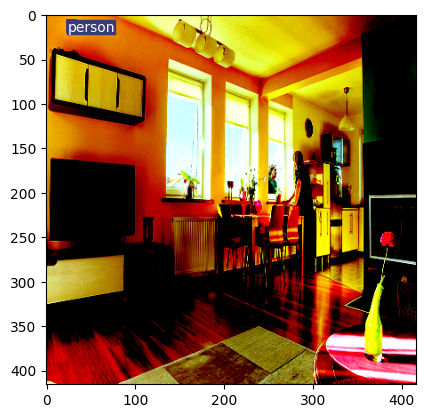

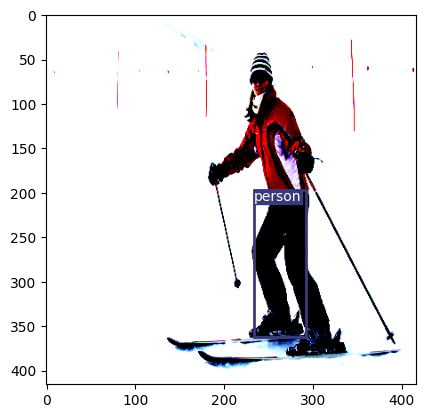

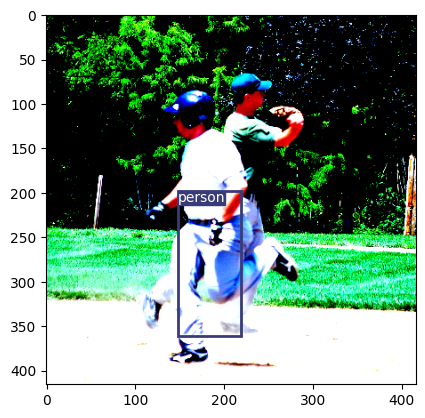

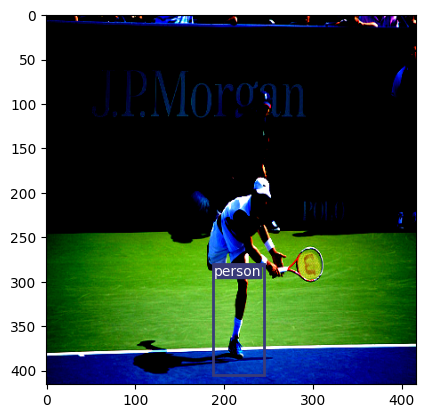

In [ ]:
model.eval()
img, target = next(iter(test_dataloader))
img = img.to(device)

with torch.no_grad():
  out = model(img)
  bboxes = [[] for _ in range(img.shape[0])]
  for i in range(3):
    batch_size, A, S, _, _ = out[i].shape
    anchor = scaled_anchors[i]
    boxes_scale_i = cells_to_bboxes(
        out[i], anchor, S=S, is_preds=True
    )
    for idx, (box) in enumerate(boxes_scale_i):
        bboxes[idx] += box

for i in range(batch_size):
  nms_boxes = non_max_suppression(
      bboxes[i], iou_threshold=0, threshold=0, box_format="midpoint",
  )
  plot_image(img[i].permute(1,2,0).detach().cpu(), nms_boxes)